In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *


update_TF, _ = get_TFcube_pars()

update_TF['g1'] = 0.0
update_TF['g2'] = 0.0
update_TF['sini'] = 0.9
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] =0.032  # old:0.032 # new:0.1185 

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.025 # old:0.025 # new:0.033
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128
update_TF['slitAngles'] = np.array([1.])

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
CPU times: user 7.88 s, sys: 181 ms, total: 8.06 s
Wall time: 6.71 s


In [3]:
TF_pars

{'g1': 0.0,
 'g2': 0.0,
 'sini': 0.9,
 'diskFrac': 1.0,
 'n_knots': 25.0,
 'knot_fraction': 0.0,
 'aspect': 0.2,
 'vcirc': 200.0,
 'sigma_intr': 0.01,
 'redshift': 0.2,
 'half_light_radius': 0.5,
 'vscale': 0.5,
 'r_0': 0.0,
 'V_0': 0.0,
 'linelist': array([('OIIa', 372.7092, 2.e-25), ('OIIb', 372.9875, 2.e-25),
        ('OIIIa', 496.0295, 2.e-25), ('OIIIb', 500.824 , 2.e-25),
        ('Halpha', 656.461 , 6.e-24)],
       dtype=[('species', '<U16'), ('lambda', '<f8'), ('flux', '<f8')]),
 'norm': 0.0,
 'abs_magnitude': None,
 'image_size': 128,
 'ngrid': 256,
 'psfFWHM': 0.5,
 'psf_g1': 0.0,
 'psf_g2': 0.0,
 'area': 785000.0,
 'pixScale': 0.032,
 'Resolution': 6000.0,
 'lambda_min': array([785.7532]),
 'lambda_max': array([789.7532]),
 'nm_per_pixel': 0.025,
 'gain': 1.0,
 'read_noise': 3.0,
 'throughput': 0.29,
 'expTime': 3600.0,
 'type_of_observation': 'slit',
 'fiber_size': 1.0,
 'fiber_offsets': [[0.0, 0.0],
  [1.0, 0.0],
  [-1.0, 0.0],
  [0.0, 1.0],
  [1.0, 1.0]],
 'slitAngles': a

In [4]:
# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    data_info['data_list'] = data['spectra']
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']  = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image'] = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']   = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

In [5]:
GaussFit = GaussFit_spec2D(data_info)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(data=GaussFit.data)

model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)

data = GaussFit.data

lambda_min = np.min(GaussFit.grid_lambda)  ; lambda_MAX = np.max(GaussFit.grid_lambda)
x_min = np.min(GaussFit.grid_pos)          ; x_MAX = np.max(GaussFit.grid_pos)

time cost in gaussFit_spec2D: 0.2077791690826416 (secs)


Text(0, 0.5, 'arcmin')

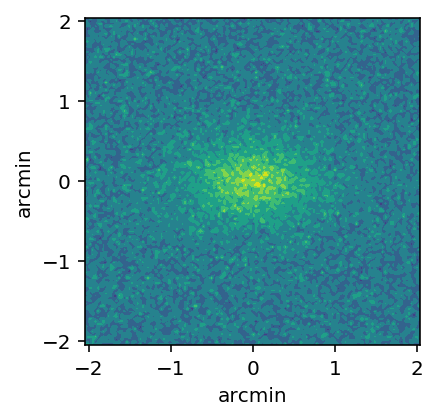

In [6]:
# check image
fig, ax = plt.subplots(1,1, figsize=(3.,3.))
ax.contourf(data_info['image'] ,extent=[x_min, x_MAX, x_min, x_MAX])

ax.set_xlabel('arcmin')
ax.set_ylabel('arcmin')

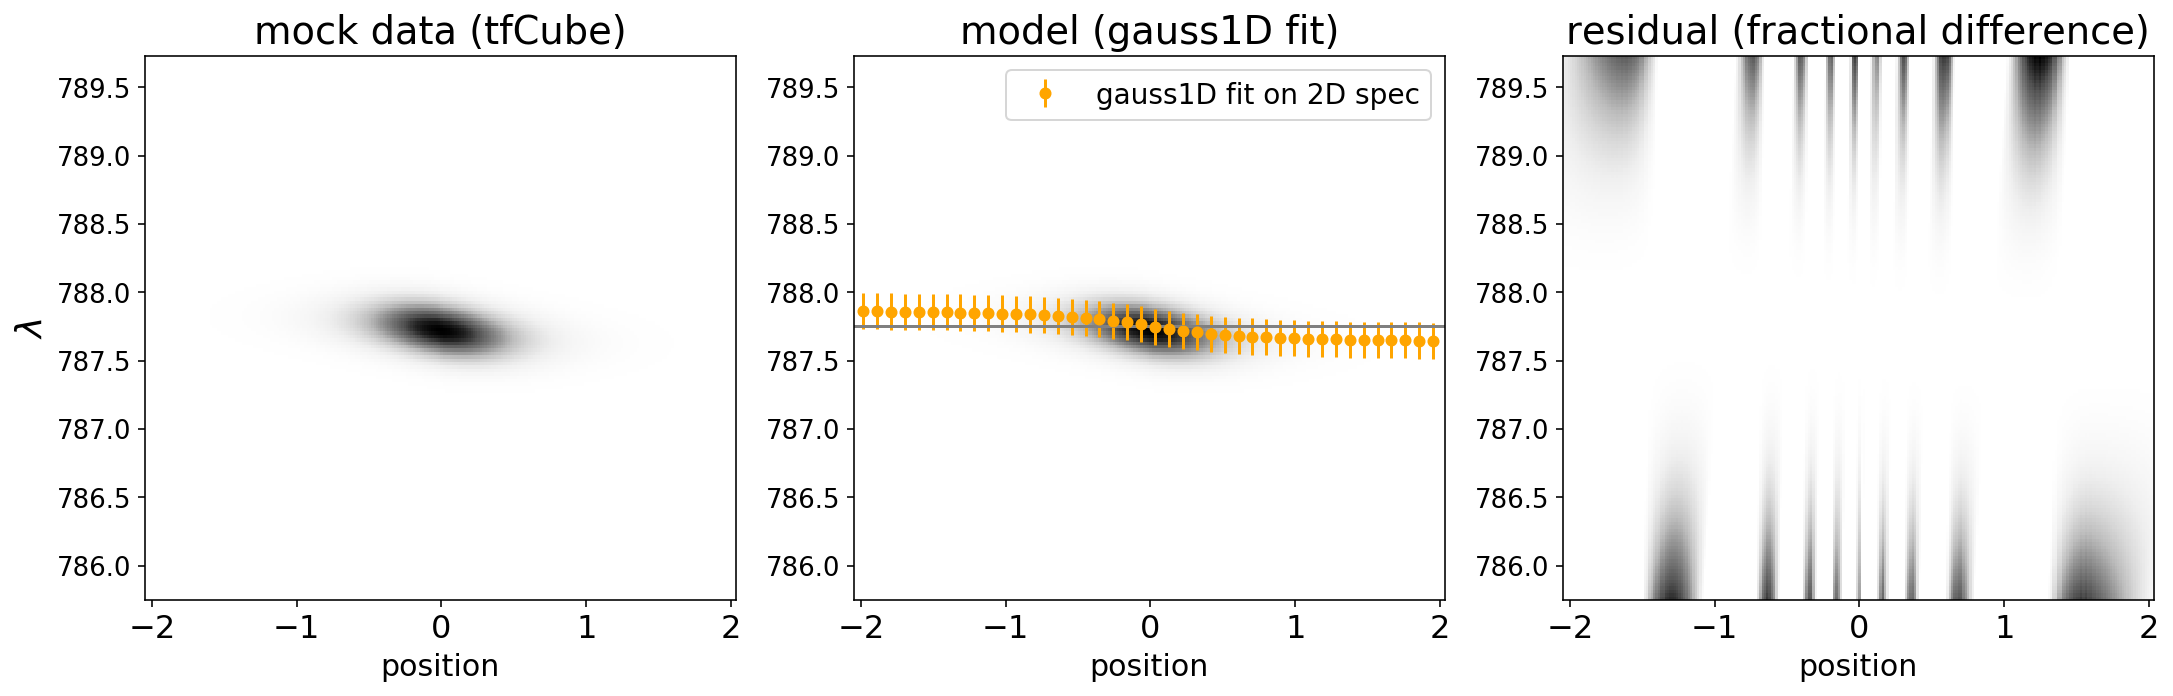

In [7]:
#%matplotlib
%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(18,5))
plt.rc('font',size=16)

ax[0].imshow(data.T ,extent=[x_min, x_MAX, lambda_min, lambda_MAX ]       , aspect='auto',cmap='Greys',vmin=0)
ax[1].imshow(model.T,extent=[x_min, x_MAX, lambda_min, lambda_MAX ]       , aspect='auto',cmap='Greys',vmin=0)
ax[2].imshow((data.T-model.T)/data.T,extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys',vmin=0)

ax[1].errorbar(np.flip(GaussFit.grid_pos)[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=5,ls='none',label='gauss1D fit on 2D spec')
#ax[1].plot(np.flip(RotFit.grid_pos)[5::6],RotFit.fitted_rot_lambdaObs[5::6],color='b',ls='-',label='arctan rot (optimizer)')


#par = RotFit.Parameter.par_fid.copy()
#fidicual_rot = RotFit.model_arctan_rotation(RotFit.grid_pos, vscale=par['vscale'], r_0=par['r_0'], vcirc=par['vcirc'], v_0=par['v_0'], redshift=par['redshift'], sini=par['sini'])
#ax[1].plot(np.flip(RotFit.grid_pos)[5::6],fidicual_rot[5::6],color='k',ls='--',label='arctan rot (fidicual)')


#par_bestfit_MC = Chain.par_bestfit(select_par_key=None, statistics='max', mode=0)
#MC_rot = RotFit.model_arctan_rotation(RotFit.grid_pos, vscale=par_bestfit_MC['vscale'][1], r_0=par['r_0'], vcirc=par_bestfit_MC['vcirc'][1], v_0=par['v_0'], redshift=par['redshift'], sini=par_bestfit_MC['sini'][1])
#ax[1].plot(np.flip(RotFit.grid_pos)[5::6],MC_rot[5::6],color='r',ls=':',label='arctan rot (MCMC)')


lambda_cen = data_info['lambda_emit']*(1.+data_info['par_fid']['redshift'])

ax[1].axhline(lambda_cen, color='gray')

for j in range(ncol):
    #ax[j].set_ylim(vcen-1.5,vcen+1.5)
    #ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual (fractional difference)')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()

Text(0, 0.5, '$\\lambda$')

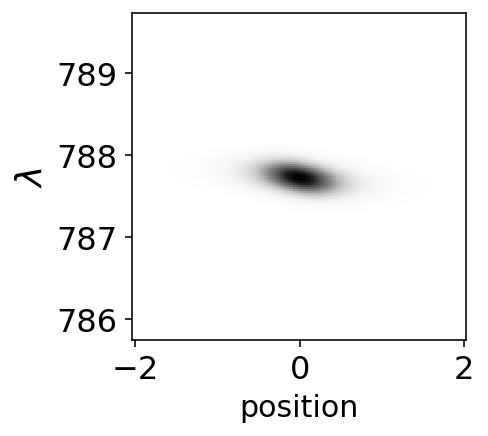

In [8]:
fig, ax = plt.subplots(1,1, figsize=(3.,3.))
plt.rc('font',size=16)

ax.imshow(data.T ,extent=[x_min, x_MAX, lambda_min, lambda_MAX ]       , aspect='auto',cmap='Greys',vmin=0)

ax.set_xlabel('position', fontsize=15)
ax.set_ylabel(r'$\lambda$', fontsize=18)